

>Dataset download



In [ ]:
import kagglehub

# Download latest version of dataset
path = kagglehub.dataset_download("pranavraikokte/covid19-image-dataset")

print("Path to dataset files:", path)


Global variables

In [2]:
IMG_size = 224
BATCH_size = 32
EPOCHS = 15
LR = 0.0001

Import libraries

In [ ]:
pip install pytorch-lightning

In [4]:
# for data preprocessing
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# for model creation
import pytorch_lightning as pl
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torchmetrics.classification import Accuracy

Dataset augmentation (applying random rotations, etc. to diverify data)

In [5]:
transform = transforms.Compose([
    transforms.Resize((IMG_size, IMG_size), antialias=True),  # Resize images to 224x224 pixels, antialias smoothens the picture after resizing
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
    transforms.RandomRotation(10),  # Rotate images by up to 10 degrees
    transforms.ColorJitter(brightness=0.1, contrast=0.1),  # Adjust brightness and contrast
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize for pretrained models
])

Dataset loading

In [6]:
test_path = path + "/Covid19-dataset/test"
train_path = path + "/Covid19-dataset/train"
data_test = ImageFolder(test_path, transform=transform)
data_train = ImageFolder(train_path, transform=transform)

train_loader = DataLoader(data_train,batch_size=BATCH_size, shuffle=True, drop_last=True)
test_loader = DataLoader(data_test, batch_size=BATCH_size, drop_last=True)

In [8]:
# number of images in test and train dataset
len(data_test), len(data_train)

(66, 251)

In [9]:
for images, labels in train_loader:
    print("Batch of images shape:", images.shape)
    print("Batch of labels shape:", labels.shape)
    break

Batch of images shape: torch.Size([32, 3, 224, 224])
Batch of labels shape: torch.Size([32])


For illustration: function that shows one image from each category

Class names: ['Covid', 'Normal', 'Viral Pneumonia']


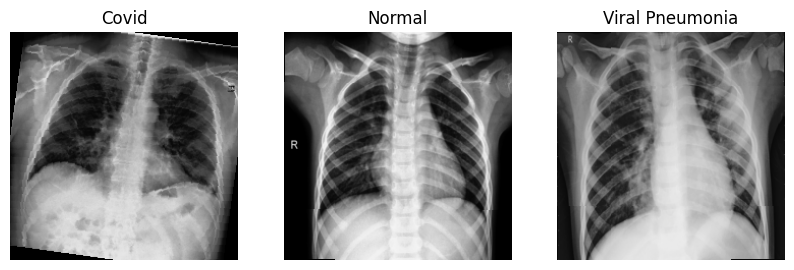

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Class names are derived from the ImageFolder dataset
class_names = data_test.classes
print("Class names:", class_names)

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

def denormalize(img, mean, std):
    img = img.clone()  # Clone the tensor
    for i in range(3):  # Apply denormalization per channel
        img[i] = img[i] * std[i] + mean[i]
    return img

images_per_class = {}

# Iterate over the test dataset
for img, label in data_test:
    if label not in images_per_class:
        images_per_class[label] = img
    if len(images_per_class) == len(class_names):
        break

# Plot images
fig, axs = plt.subplots(1, len(images_per_class), figsize=(10, 5))
for i, (label, img) in enumerate(images_per_class.items()):
    img = denormalize(img, mean, std)
    img = img.clamp(0, 1)
    axs[i].imshow(img.permute(1, 2, 0).numpy())  # Convert from [C, H, W] to [H, W, C]
    axs[i].set_title(class_names[label])
    axs[i].axis('off')

plt.show()


Define model

In [27]:
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import OneCycleLR

class CovidXrayClassifier(pl.LightningModule):
    def __init__(self, num_classes=3, lr=0.0001):
        super(CovidXrayClassifier, self).__init__()

        #choose model - uncomment to use different models or add new one

        #resnet50, resnet101
        self.model = models.resnet101(pretrained=True)
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Sequential(nn.Dropout(p=0.6), nn.Linear(num_ftrs, num_classes))

        #densenet121
        #self.model = models.densenet121(pretrained=True)
        #num_ftrs = self.model.classifier.in_features
        #self.model.classifier = nn.Sequential(nn.Dropout(p=0.6), nn.Linear(num_ftrs, num_classes))

        # Metrics
        self.lr = lr
        self.criterion = nn.CrossEntropyLoss()
        self.train_accuracy = Accuracy(task="multiclass", num_classes=num_classes)
        self.val_accuracy = Accuracy(task="multiclass", num_classes=num_classes)

        # Store metrics (these are metrics that are different for each epoch)
        self.train_losses = []
        self.val_losses = []
        self.train_accs = []
        self.val_accs = []

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = self.criterion(outputs, labels)
        acc = self.train_accuracy(outputs, labels)
        self.log('train_loss', loss, on_epoch=True, prog_bar=True)
        self.log('train_acc', acc, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = self.criterion(outputs, labels)
        acc = self.val_accuracy(outputs, labels)
        self.log('val_loss', loss, on_epoch=True, prog_bar=True)
        self.log('val_acc', acc, on_epoch=True, prog_bar=True)
        return loss

    def on_train_epoch_end(self):
        self.train_losses.append(self.trainer.callback_metrics["train_loss"].item())
        self.train_accs.append(self.trainer.callback_metrics["train_acc"].item())

    def on_validation_epoch_end(self):
        self.val_losses.append(self.trainer.callback_metrics["val_loss"].item())
        self.val_accs.append(self.trainer.callback_metrics["val_acc"].item())

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.lr, weight_decay=1e-3)
        scheduler = OneCycleLR(optimizer, max_lr=self.lr, steps_per_epoch=len(train_loader), epochs=EPOCHS)
        return {"optimizer": optimizer, "lr_scheduler": scheduler}


Set up WANDB to save trained model

In [13]:
import wandb
from pytorch_lightning.loggers import WandbLogger

Train model

In [ ]:
# Initialize Wandb Logger
wandb_logger = WandbLogger(project="CovidXrayProject", name="CovidXrayClassifier_resnet101")

# Initialize and train model
model = CovidXrayClassifier()
trainer = pl.Trainer(max_epochs=EPOCHS, accelerator='gpu', logger=wandb_logger)
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=test_loader)

wandb.finish()

Result metrics

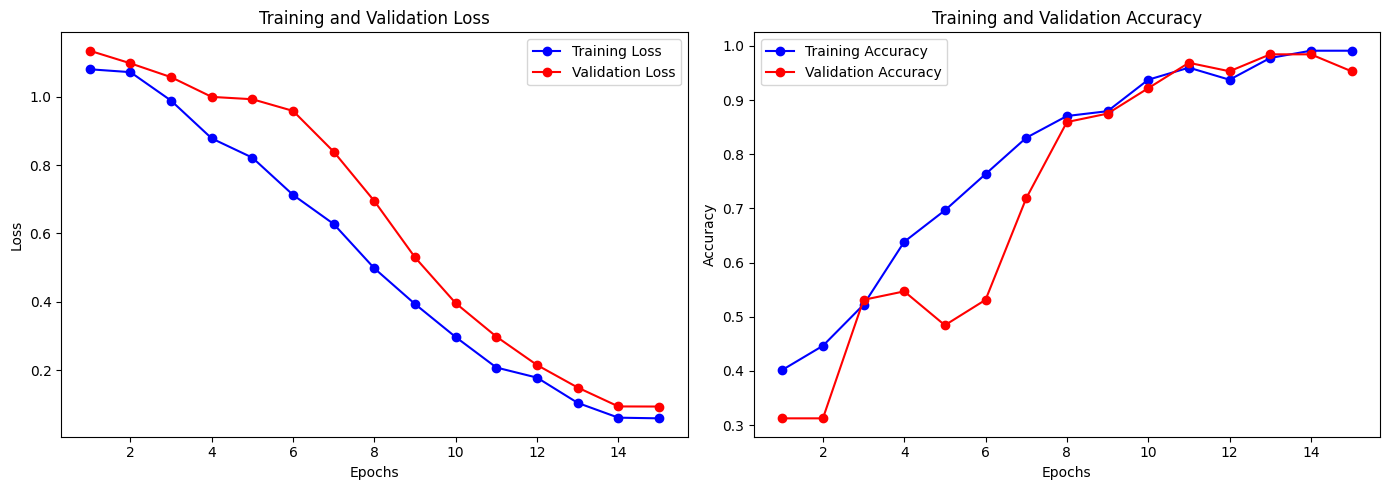

In [29]:
def align_lists(*lists):
    min_length = min(len(lst) for lst in lists)
    return [lst[:min_length] for lst in lists]

# Call the alignment function
train_losses, val_losses, train_accs, val_accs = align_lists(
    model.train_losses, model.val_losses, model.train_accs, model.val_accs
)

# function for plottin relevant metrics
def plot_metrics(train_losses, val_losses, train_accs, val_accs):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(14, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'bo-', label='Training Loss')
    plt.plot(epochs, val_losses, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_accs, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot the aligned metrics
plot_metrics(train_losses, val_losses, train_accs, val_accs)

Confusion matrix

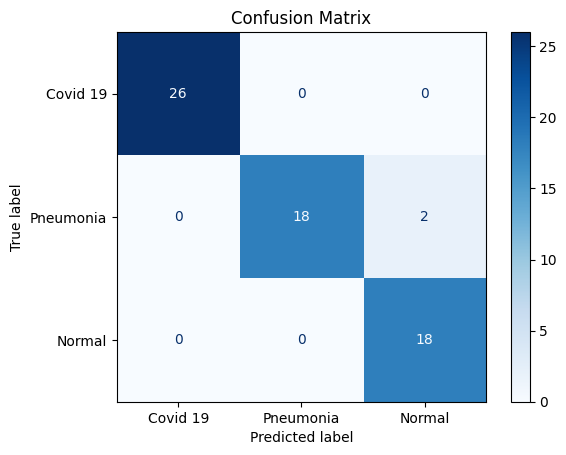

In [33]:
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Model in evaluation mode
model.eval()

# predicts and labels
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        images, labels = batch
        images = images.to(model.device)
        labels = labels.to(model.device)

        # Model predictions
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)

        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())

all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)

# Calculation of confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Display of cm
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Covid 19", "Pneumonia", "Normal"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


Function for classifying given image

In [34]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F

def classify_image(model, image_path, class_names):
    # model set in evaluation mode
    model.eval()

    # Transform the image
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize to match model input
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize with ImageNet stats
    ])

    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0)

    # Classification
    with torch.no_grad():
        output = model(image_tensor)
        probabilities = F.softmax(output, dim=1)
        confidence, predicted_class = torch.max(probabilities, 1)

    # Print the predicted class label and confidence
    predicted_label = class_names[predicted_class.item()]
    confidence_score = confidence.item() * 100  # Convert to percentage
    print(f'Predicted class: {predicted_label} with confidence: {confidence_score:.2f}%')

    # Display the image
    plt.imshow(image)
    plt.title(f'Predicted: {predicted_label} ({confidence_score:.2f}%)')
    plt.axis('off')
    plt.show()

    return predicted_label, confidence_score


Predicted class: Covid with confidence: 91.78%


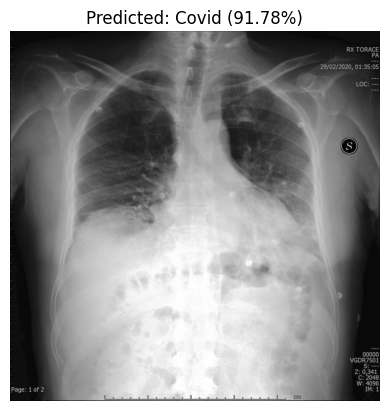

In [35]:
# Example
image_path = path + "/Covid19-dataset/test/Covid/098.jpeg" # I chose one random image (here it is covid example, can be changed by just choosing different path)
predicted_label = classify_image(model, image_path, class_names)